Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [23]:
# importing necessary packages
import pandas as pd

# loading Philadelphia bike station data
philly = pd.read_csv("../data/philly.csv")
if "Unnamed: 0" in philly.columns:
    philly = philly.drop(columns=["Unnamed: 0"])
philly = philly.reset_index(drop=True)

# loading cleaned FourSquare POI data
fs_phi_poi_clean = pd.read_csv("../data/fs_phi_poi_clean.csv")
if "Unnamed: 0" in fs_phi_poi_clean.columns:
    fs_phi_poi_clean = fs_phi_poi_clean.drop(columns=["Unnamed: 0"])
fs_phi_poi_clean = fs_phi_poi_clean.reset_index(drop=True)

# loading cleaned Yelp POI data
yp_phi_poi_clean = pd.read_csv("../data/yp_phi_poi_clean.csv", index_col=0)
if "Unnamed: 0" in yp_phi_poi_clean.columns:
    yp_phi_poi_clean = yp_phi_poi_clean.drop(columns=["Unnamed: 0"])
yp_phi_poi_clean = yp_phi_poi_clean.reset_index(drop=True)
# cleaning note: removing unnecessary index column that was saved during the export (oopsies)

# adding a 'source' column to distinguish between data retrieval sources
fs_phi_poi_clean["source"] = "Foursquare"
yp_phi_poi_clean["source"] = "Yelp"

# standardizing column names for consistency before combining
fs_phi_poi_clean = fs_phi_poi_clean.rename(columns={"distance_m": "distance_to"})
fs_phi_poi_clean = fs_phi_poi_clean.rename(columns={"poi_name": "name"})
philly = philly.rename(columns={"name": "station_name"})

# aligning columns across both datasets
all_columns = set(fs_phi_poi_clean.columns).union(set(yp_phi_poi_clean.columns))
fs_phi_poi_clean = fs_phi_poi_clean.reindex(columns=all_columns)
yp_phi_poi_clean = yp_phi_poi_clean.reindex(columns=all_columns)

# combining the Yelp and FourSqaure data into one DataFrame
yelp_w_fs = pd.concat([fs_phi_poi_clean, yp_phi_poi_clean], ignore_index=True)

In [64]:
# merging combined Yelp/FourSquare data with CityBikes data
# using station name to join tables
full_combined = yelp_w_fs.merge(philly, on="station_name", how="left")
# renaming latitude and longitude columns to specify between station and poi
full_combined = full_combined.rename(columns={
    "latitude_x": "poi_latitude",
    "longitude_x": "poi_longitude",
    "latitude_y": "station_latitude",
    "longitude_y": "station_longitude"
})

# sorting data so that Yelp entries appear first
full_combined_sorted = full_combined.sort_values(by="source", ascending=False)
# removing duplicate POIs based on name and coordinates
# keeping Yelp entries as they are more complete
full_combined_clean = full_combined_sorted.drop_duplicates(subset=["name", "poi_latitude", "poi_longitude"], keep="first")

In [65]:
# saving combined data as a CSV
full_combined_clean.to_csv("combined_all.csv")

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

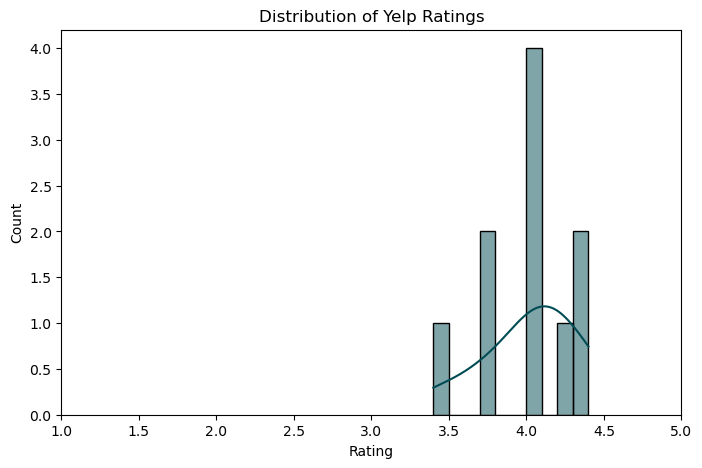

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
# plotting distribution of Yelp ratings with a histogram and KDE curve
sns.histplot(data=full_combined[full_combined["source"] == "Yelp"], x="rating", bins=10, kde=True, color="#004C54")
# note: #004C54 is the hexcode for "Midnight Green" which is the official colour of the Philadelphia Eagles!
plt.title("Distribution of Yelp Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xlim(1,5)
plt.show()

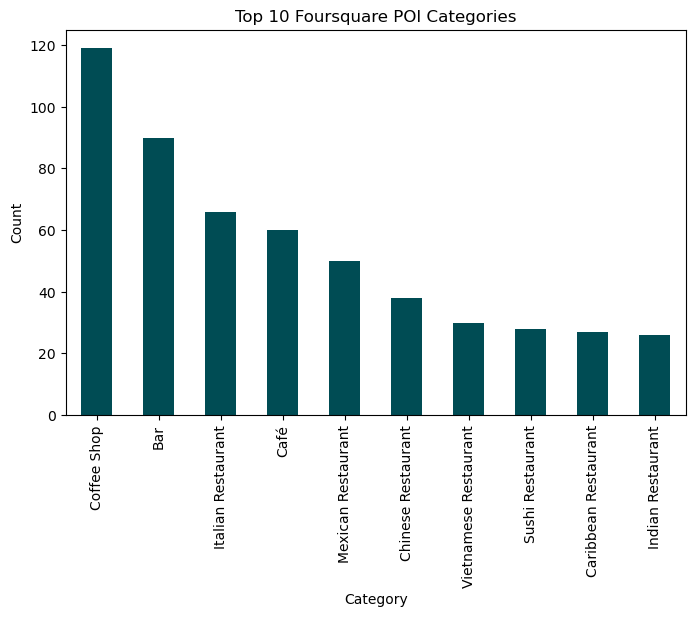

In [85]:
# plotting the top 10 most common FourSquare POI categories with a bar chart
fs_phi_poi_clean["category"].value_counts().head(10).plot(kind="bar",figsize=(8, 5),color="#004C54")
plt.title("Top 10 Foursquare POI Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

In [60]:
# counting number of POIs near each station
poi_per_station = full_combined_clean.groupby("station_name").size().reset_index(name="poi_count")
# extracting bike counts for each station
bike_counts = philly[["station_name", "num_bikes"]]
# merging POI counts with bike counts
station_summary = pd.merge(poi_per_station, bike_counts, on="station_name", how="left")

In [68]:
# saving merged data to CSV
station_summary.to_csv("station_summary.csv")

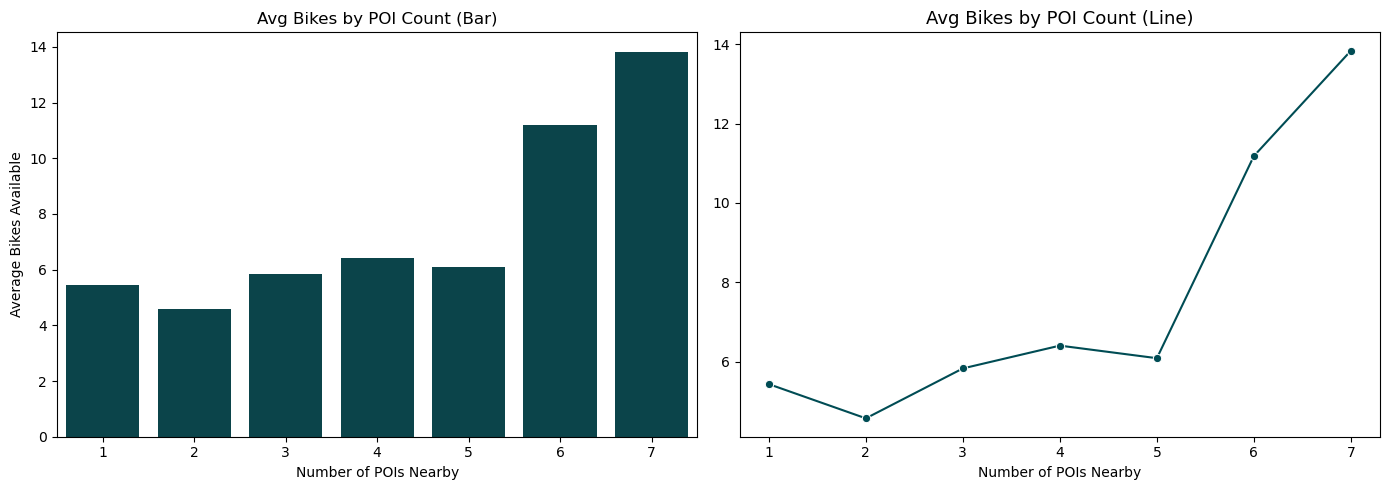

In [84]:
# grouping by number of POIs and calculating average number of available bikes
grouped = station_summary.groupby("poi_count")["num_bikes"].mean().reset_index()

# setting up a figure with two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# plotting a bar chart on the left
sns.barplot(data=grouped, x="poi_count", y="num_bikes", color="#004C54", ax=axes[0])
axes[0].set_title("Avg Bikes by POI Count (Bar)")
axes[0].set_xlabel("Number of POIs Nearby")
axes[0].set_ylabel("Average Bikes Available")

# plotting a line plot on the right
sns.lineplot(data=grouped, x="poi_count", y="num_bikes", marker="o", color="#004C54", ax=axes[1])
axes[1].set_title("Avg Bikes by POI Count (Line)", fontsize=13)
axes[1].set_xlabel("Number of POIs Nearby")
axes[1].set_ylabel("")

# resolving spacing issues
plt.tight_layout()
plt.show()

I wanted to explore whether station surroundings, both in terms of venue count and type, relate to user experience (Yelp ratings) or operational decisions (number of bikes available).

1.	Distribution of Yelp Ratings:
    Most businesses near bike stations are rated above 3.5. While this doesn’t directly confirm whether proximity to a station impacts quality, it offers a general sense of user satisfaction in these areas.

2.	Top 10 Foursquare POI Categories:
    This chart highlights the functional makeup of the areas surrounding bike stations, with a focus on food and beverage-related businesses. It helps contextualize what types of destinations riders may be traveling to or from.

3.	Average Bikes Available vs. Number of POIs Nearby:
    This visualization suggests a potential correlation between POI density and the number of bikes available. Stations surrounded by more points of interest tend to have higher average bike availability, which could reflect strategic stocking decisions in high-traffic zones.

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [90]:
# loading all previously created CSV files
philly = pd.read_csv("../data/philly.csv")
fs_phi_poi_clean = pd.read_csv("../data/fs_phi_poi_clean.csv")
fs_phi_poi_raw = pd.read_csv("../data/fs_phi_poi_raw.csv")
yp_phi_poi_clean = pd.read_csv("../data/yp_phi_poi_clean.csv")
yp_phi_poi_raw = pd.read_csv("../data/yp_phi_poi.csv")
combined_all = pd.read_csv("../data/combined_all.csv")
station_summary = pd.read_csv("../data/station_summary.csv")

In [86]:
import sqlite3

# creating SQLite database
conn = sqlite3.connect("bike_station_analysis.db")

# exporting datasets to individual tables in the previously created database
combined_all.to_sql("combined_all", conn, if_exists="replace", index=False)
station_summary.to_sql("station_summary", conn, if_exists="replace", index=False)
fs_phi_poi_clean.to_sql("foursquare_clean", conn, if_exists="replace", index=False)
fs_phi_poi_raw.to_sql("foursquare_raw", conn, if_exists="replace", index=False)
philly.to_sql("citybikes", conn, if_exists="replace", index=False)
yp_phi_poi_clean.to_sql("yelp_clean", conn, if_exists="replace", index=False)
yp_phi_poi_raw.to_sql("yelp_raw", conn, if_exists="replace", index=False)

# creating a cursor for executing SQL queries (used as a double checking measure)
cursor = conn.cursor()
# closing the connection (and also moving the db to data file)
conn.close()

Look at the data before and after the join to validate your data.

In [91]:
import sqlite3
conn = sqlite3.connect("../data/bike_station_analysis.db")

print(pd.read_sql("SELECT COUNT(*) FROM combined_all", conn))
print(len(combined_all))

   COUNT(*)
0       561
561


In [93]:
print(pd.read_sql("SELECT COUNT(*) FROM yelp_clean", conn))
print(len(yp_phi_poi_clean))
# this is low, but in previous steps I removed businesses that appeared at multiple stations - adjusting it to only show the business once at the POI it is nearest to

   COUNT(*)
0        10
10


In [94]:
print(pd.read_sql("SELECT COUNT(*) FROM foursquare_clean", conn))
print(len(fs_phi_poi_clean))

   COUNT(*)
0       937
937


In [96]:
print(pd.read_sql("""SELECT COUNT(*) FROM combined_all WHERE station_latitude IS NULL OR station_longitude IS NULL""", conn))
combined_all[(combined_all["station_latitude"].isna()) | (combined_all["station_longitude"].isna())].shape[0]

   COUNT(*)
0         0


0

In [97]:
print(pd.read_sql("SELECT * FROM combined_all LIMIT 3", conn))
print(combined_all.head(3))

   Unnamed: 0  distance_to source        station_name  review_count  \
0         946   353.272424   Yelp   Broad & Passyunk          126.0   
1         945   346.915577   Yelp  Berks Station, MFL         317.0   
2         944   307.490471   Yelp        17th & Green         525.0   

              business_id  rating                     name price  \
0  vq73W-SHrwBgXzQ__0yV2w     4.1  Second District Brewing    $$   
1  BPBTCvmUfRnEH6yyABzOzA     4.1         Evil Genius Beer    $$   
2  Mwc3n5Psw9wRaQ22vZWDYQ     4.4                Bar Hygge    $$   

  poi_longitude                                    category poi_latitude  \
0          None               Breweries, Beer Bar, American         None   
1          None                     Breweries, Beer Gardens         None   
2          None  Comfort Food, Breakfast & Brunch, Brewpubs         None   

                                      address  station_longitude  \
0  1939 S Bancroft St, Philadelphia, PA 19145          -75.16904   
1